In [1]:
# Imports 
from gurobipy import *
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import utility functions
from utils import *

# These come as a part of the standard Python library. 
import warnings 
import re
import math
import copy
import random
import pickle
import os
import time


# Suppress warnings
warnings.simplefilter("ignore")

%matplotlib inline
%pylab inline

# Plot styles
plt.style.use('fivethirtyeight')

# Set up the necessary directories
req_dirs = ["models", "plots", "zipcode_data"]
for req_dir in req_dirs: 
    if not os.path.exists(req_dir):
        os.mkdir(req_dir)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load datasets: for example .... 
current_county = "Fulton County"
current_state = "Georgia"

county_state_string = generate_county_state_str(current_county, current_state)
plot_path = "plots/{}".format(county_state_string)
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

default_encoding = "ISO-8859-1"

# Load raw data
print("Loading demographic data from csv for {}, {}...\n".format(current_county, current_state))
full_pdb16_tr_df = pd.read_csv("raw_data/pdb2016trv8_us.csv", encoding=default_encoding)

# Filter for specified County
current_tr_df = df_for_county(current_county, current_state, full_pdb16_tr_df)
print("Data preview ({} total rows):".format(len(current_tr_df)))
print(current_tr_df.head())

Loading demographic data from csv for Fulton County, Georgia...

Data preview (204 total rows):
             GIDTR  State State_name  County    County_name  Tract  Flag  \
19276  13121000100     13    Georgia     121  Fulton County    100   NaN   
19277  13121000200     13    Georgia     121  Fulton County    200   NaN   
19278  13121000400     13    Georgia     121  Fulton County    400   NaN   
19279  13121000500     13    Georgia     121  Fulton County    500   NaN   
19280  13121000600     13    Georgia     121  Fulton County    600   NaN   

       Num_BGs_in_Tract  LAND_AREA  AIAN_LAND  \
19276               4.0      1.292        0.0   
19277               5.0      1.111        0.0   
19278               2.0      0.601        0.0   
19279               3.0      1.273        0.0   
19280               1.0      0.559        0.0   

                    ...                 pct_TEA_MailOutMailBack_CEN_2010  \
19276               ...                                            100.0   


In [3]:
# Load raw geographic data
print("Loading geographic tract data from csv...\n")
gaz_tracts_df = pd.read_csv("raw_data/2017_Gaz_tracts_national.csv", encoding=default_encoding)
gaz_tracts_df = gaz_tracts_df.drop(columns="Column1") # drops an empty column from bad csv formatting
print("Loaded {} rows of geographic tract data...\n".format(len(gaz_tracts_df)))

# Append latitude and longitudes 
min_geo_id = min(current_tr_df['GIDTR'].tolist())
max_geo_id = max(current_tr_df['GIDTR'].tolist())
print("Appending geographic data to demographic data...\n")
map_lat_long_geoid(min_geo_id, max_geo_id, current_tr_df, gaz_tracts_df)

# Filter columns for relevant attributes
print("Filtering dataframe for relevant attributes... \n")
income_current_tr_df = current_tr_df[['Latitude', 
                                    'Longitude', 
                                    'LAND_AREA', 
                                    'Tot_Population_ACS_10_14', 
                                    'Med_HHD_Inc_ACS_10_14', 
                                    'Prs_Blw_Pov_Lev_ACS_10_14', 
                                    'PUB_ASST_INC_ACS_10_14']]
print("Data preview ({} total rows):".format(len(income_current_tr_df)))
print(income_current_tr_df.head())

Loading geographic tract data from csv...

Loaded 74001 rows of geographic tract data...

Appending geographic data to demographic data...

Filtering dataframe for relevant attributes... 

Data preview (204 total rows):
        Latitude  Longitude  LAND_AREA  Tot_Population_ACS_10_14  \
19276  33.799799 -84.354925      1.292                    4469.0   
19277  33.791633 -84.364199      1.111                    6101.0   
19278  33.788324 -84.378511      0.601                    1642.0   
19279  33.796142 -84.385452      1.273                    5159.0   
19280  33.785386 -84.405654      0.559                    6416.0   

      Med_HHD_Inc_ACS_10_14  Prs_Blw_Pov_Lev_ACS_10_14  PUB_ASST_INC_ACS_10_14  
19276              $128,578                      364.0                    45.0  
19277              $101,100                      418.0                    74.0  
19278               $92,273                       97.0                     0.0  
19279               $81,615                    

In [4]:
# Remove rows with null values 
old_len = len(income_current_tr_df)
for header in list(income_current_tr_df):
    income_current_tr_df = income_current_tr_df[pd.notnull(income_current_tr_df[header])]
new_len = len(income_current_tr_df)
print("Removed {} rows from the dataframe due to null values...\n".format(old_len - new_len))

# Convert income attribute from string to float
remove_characters = str.maketrans("", "", "$,")
income_list = list(income_current_tr_df['Med_HHD_Inc_ACS_10_14'])
if len(income_list) != 0 and isinstance(income_list[0], str):
    income_list_float = [float(income.translate(remove_characters)) for income in income_list]
    income_current_tr_df['Med_HHD_Inc_ACS_10_14'] = income_list_float

print("Data preview ({} total rows):".format(len(income_current_tr_df)))
print(income_current_tr_df.head())

Removed 4 rows from the dataframe due to null values...

Data preview (200 total rows):
        Latitude  Longitude  LAND_AREA  Tot_Population_ACS_10_14  \
19276  33.799799 -84.354925      1.292                    4469.0   
19277  33.791633 -84.364199      1.111                    6101.0   
19278  33.788324 -84.378511      0.601                    1642.0   
19279  33.796142 -84.385452      1.273                    5159.0   
19280  33.785386 -84.405654      0.559                    6416.0   

       Med_HHD_Inc_ACS_10_14  Prs_Blw_Pov_Lev_ACS_10_14  \
19276               128578.0                      364.0   
19277               101100.0                      418.0   
19278                92273.0                       97.0   
19279                81615.0                      593.0   
19280                44612.0                     2230.0   

       PUB_ASST_INC_ACS_10_14  
19276                    45.0  
19277                    74.0  
19278                     0.0  
19279               

In [5]:
# Collect zipcodes: if false then retrieves all zipcodes, otherwise uses a previously saved file with the "True" option. 
print("Retrieving zipcode data...\n")
zipcode_map, zipcode_list = load_zipcode_data(county_state_string, True)

# Append zipcode
print("Appending zipcodes to dataframe...\n")
income_current_tr_df['Zipcode'] = pd.Series(zipcode_list, index = income_current_tr_df.index)

# Remove rows with null zipcode 
old_len = len(income_current_tr_df)
income_current_tr_df = income_current_tr_df[pd.notnull(income_current_tr_df['Zipcode'])]
new_len = len(income_current_tr_df)
print("Removed {} rows from the dataframe due to null values...\n".format(old_len - new_len))

#print how many rows removed??

# Enumerate customers
customers = income_current_tr_df.index.tolist()

# Split large dataframe into neighborhoods
neighborhood_customer_map = {}
neighborhoods = list(set(income_current_tr_df['Zipcode'].tolist()))
neighborhood_locs = []
neighborhood_incomes = []
neighborhood_populations = []
neighborhood_longitudes = []
neighborhood_latitudes = []

# Calculate neighborhood-specific attributes
for neighborhood in neighborhoods:
    neighborhood_customers = income_current_tr_df[income_current_tr_df['Zipcode'] == neighborhood]
    neighborhood_customer_map[neighborhood] = neighborhood_customers
    longs = neighborhood_customers['Longitude'].tolist()
    lats = neighborhood_customers['Latitude']. tolist()
    incomes = neighborhood_customers['Med_HHD_Inc_ACS_10_14'].tolist()
    populations = neighborhood_customers['Tot_Population_ACS_10_14'].tolist()
    
    avg_long = sum(longs) / len(longs)
    avg_lat = sum(lats) / len(lats)
    avg_incomes = sum(incomes) / len(incomes)
    total_population = sum(populations)
    
    neighborhood_locs.append((avg_lat, avg_long))
    neighborhood_longitudes.append(avg_long)
    neighborhood_latitudes.append(avg_lat)
    neighborhood_incomes.append(avg_incomes)
    neighborhood_populations.append(total_population)
    
#plot these onto a grid so that we can see the neighborhoods and different attributes: income could be the color of the dots, size would be the size of the circle


# Set the warehouse location to the be the centroid of all neighborhoods
# and generate the distances to each neighborhood
warehouse_loc = np.mean(neighborhood_locs, axis = 0)
neighborhood_distances = [numpy.linalg.norm(warehouse_loc - neighborhood_locs[b]) for b in range(0, len(neighborhood_locs))]

# Create a map of zipcode to customers 
zipcode_customer_map = {}
for i, customer in enumerate(customers):
    zipcode = income_current_tr_df.iloc[i]['Zipcode']
    if zipcode not in zipcode_customer_map:
        zipcode_customer_map[zipcode] = [i]
    else:
        zipcode_customer_map[zipcode].append(i)
        
neighborhood_customer_map = zipcode_customer_map

print("Data preview ({} total rows):".format(len(income_current_tr_df)))
print(income_current_tr_df.head())

Retrieving zipcode data...

Using cached copy of zipcode data from 'zipcode_data/Fulton_County_Georgia.pkl'... 

Appending zipcodes to dataframe...

Removed 1 rows from the dataframe due to null values...

Data preview (199 total rows):
        Latitude  Longitude  LAND_AREA  Tot_Population_ACS_10_14  \
19276  33.799799 -84.354925      1.292                    4469.0   
19277  33.791633 -84.364199      1.111                    6101.0   
19278  33.788324 -84.378511      0.601                    1642.0   
19279  33.796142 -84.385452      1.273                    5159.0   
19280  33.785386 -84.405654      0.559                    6416.0   

       Med_HHD_Inc_ACS_10_14  Prs_Blw_Pov_Lev_ACS_10_14  \
19276               128578.0                      364.0   
19277               101100.0                      418.0   
19278                92273.0                       97.0   
19279                81615.0                      593.0   
19280                44612.0                     2230.0   


Number of Census Tract Points: 199


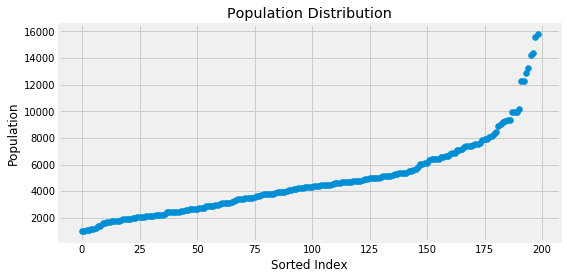

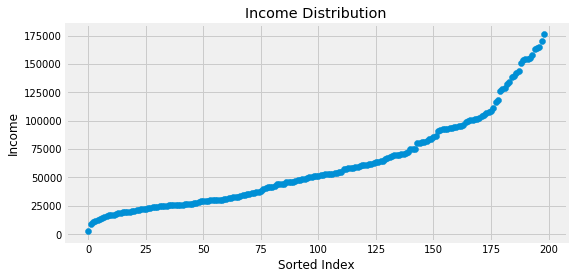

In [6]:
# Calculating Each Customer's Mean Demand

customers = list(income_current_tr_df.index)
populations = np.array(income_current_tr_df['Tot_Population_ACS_10_14'].tolist())
incomes = np.array(income_current_tr_df['Med_HHD_Inc_ACS_10_14'].tolist())
longitudes = np.array(income_current_tr_df['Longitude'].tolist())
latitudes = np.array(income_current_tr_df['Latitude'].tolist())
    
print("Number of Census Tract Points: {}".format(len(customers)))
fig = plt.figure(figsize=(8, 4))
sorted_pops = sorted(populations)
plt.scatter(list(range(0, len(sorted_pops))), sorted_pops)
plt.title("Population Distribution")
plt.xlabel("Sorted Index")
plt.ylabel("Population")
plt.show()

fig = plt.figure(figsize=(8, 4))
sorted_incs = sorted(incomes)
plt.scatter(list(range(0, len(sorted_incs))), sorted_incs)
plt.title("Income Distribution")
plt.xlabel("Sorted Index")
plt.ylabel("Income")
plt.show()

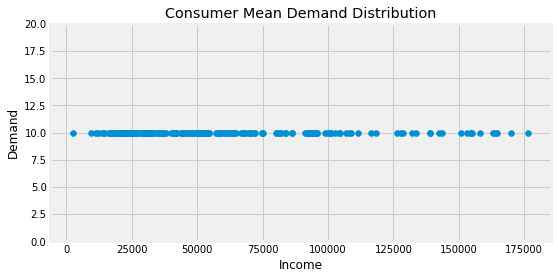

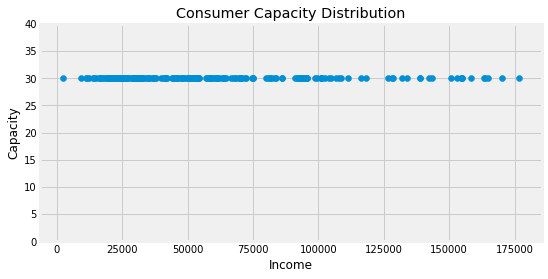

In [7]:
Q = 140   # Truck capacity
H = []    # Customer capacity

S = 2.5   # Standard deviation of demand
T = 100   # Time periods
P = 24600 # Poverty line

H_LO = 30 # Low-income consumer capacity
H_HI = 30 # High-income consumer capacity
D_LO = 10 # Lower bound for consumer demand
D_HI = 10 # Upper bound for consumer demand

alpha = (D_HI - D_LO) / (max(incomes) - min(incomes))

N = len(customers)
betas = [1 for n in range(N)]  # Uncertainty set parameter

customer_mean_demands = []
poverty_mask = []
worst_case_demands = []

for n in range(N):
    customer_income = incomes[n]
    customer_mean_demand = alpha * (customer_income  - min(incomes)) + D_LO
    customer_mean_demands.append(customer_mean_demand)
    if (customer_income < P):
        H.append(H_LO)
        poverty_mask.append(True)
        worst_case_demands.append(round(customer_mean_demand + betas[n] * S, 2))
    else:
        H.append(H_HI)
        poverty_mask.append(False)
        worst_case_demands.append(round(customer_mean_demand + betas[n] * S, 2))

fig = plt.figure(figsize=(8, 4))
plt.scatter(incomes, customer_mean_demands)
plt.title("Consumer Mean Demand Distribution")
plt.xlabel("Income")
plt.ylabel("Demand")
plt.ylim([0, 20])
plt.savefig('{}/Mean_Demand_Distribution_Constant.png'.format(plot_path))
plt.show()

fig = plt.figure(figsize=(8, 4))
plt.scatter(incomes, H)
plt.title("Consumer Capacity Distribution")
plt.xlabel("Income")
plt.ylabel("Capacity")
plt.ylim([0, 40])
plt.savefig('{}/Customer_Capacity_Varying.png'.format(plot_path))
plt.show()

In [ ]:
shuffle_sol_dict = {}

for shuffle in range(0, 20):
    incomes = income_current_tr_df['Med_HHD_Inc_ACS_10_14'].tolist()
    indices = list(range(0, len(customers)))
    random.shuffle(indices)
    shuffled_incomes = [incomes[index] for index in indices]
    
    H = []
    customer_mean_demands = []
    poverty_mask = []
    worst_case_demands = []

    for n in range(N):
        customer_income = shuffled_incomes[n]
        customer_mean_demand = alpha * (customer_income  - min(shuffled_incomes)) + D_LO
        customer_mean_demands.append(customer_mean_demand)
        if (customer_income < P):
            H.append(H_LO)
            poverty_mask.append(True)
            worst_case_demands.append(round(customer_mean_demand + betas[n] * S, 2))
        else:
            H.append(H_HI)
            poverty_mask.append(False)
            worst_case_demands.append(round(customer_mean_demand + betas[n] * S, 2))
    
    
    # Setting the minimum number of vehicles 
    V = 22 # round(sum(worst_case_demands)/Q) + 1
    automate_v = False # True # Set to True to automate finding the minimum number of Vehicles 
    max_runtime = 3600 # In seconds
    print("Number of vehicles must be at least: {}".format(V))

    sol_dict = {}

    # Creates a string based on the parameter attributes, such that it can later be recovered
    county_prefix = "{}-".format(county_state_string)
    model_hash = "Arxiv_Constant_Demand_Constant_Capacity"

    print("Optimizing: {} ... \n".format(model_hash))

    ## Data
    D = np.array(worst_case_demands) # Worst Case Demand
    C = np.array(neighborhood_distances) # Costs of each path
    B = len(neighborhoods) # Number of neighborhoods
    N = len(customers) # Number of customers
    Y = neighborhoods # Neighborhood list
    Z = zipcode_customer_map # Mapping of zipcodes to customers in those zipcodes

    ## Model
    min_v_found = False
    v_lower = V
    v_upper = 2 * V
    last_run_successful = False
    last_runtime = 0
    while min_v_found is False:
        if v_upper - v_lower <= 1 and last_run_successful:
            V = v_upper
            min_v_found = True
            break
        min_v_found = min_v_found or (not automate_v)

        print("Vehicle bounds [{},{}]...\n".format(v_lower, v_upper))
        print("Running model with {} vehicles...\n".format(V))
        try:
            for past_V in list(sol_dict.keys()):
                if past_V <= V:
                    obj_val = sol_dict['obj_val']
                    x_sol = sol_dict['x_sol']
                    a_sol = sol_dict['a_sol']
                    v_upper = V
                    V_next = (V + v_lower) // 2
                    V = V_next
                    last_run_successful = True
                    continue

            m = Model()

            ## Decision Variables

            # a(t = 1..T, b = 1..B): 1 if neighborhood b is serviced in time t, 0 otherwise
            # x(t = 1.. T, n = 1..N): amount of stock customer n is serviced with in time i
            # s(t = 1..T , n = 1..N): amount of stock customer n begins with in time t
            a = m.addVars(T, B, vtype = GRB.INTEGER)
            x = m.addVars(T, N)
            s = m.addVars(T, N)

            ## Objective

            # Minimize cost of paths taken over all time periods
            m.setObjective(
                quicksum(
                    [C[b] * a[t, b] for t in range(0, T) for b in range(0, B)]
                ), GRB.MINIMIZE
            )

            ## Constraints
            # Customers do not stock out
            m.addConstrs(
                s[t, n] >= 0
                for t in range(0, T) 
                for n in range(0, N)
            )

            # Stock starts at capacity for each customer
            m.addConstrs(
                s[0, n] == H[n]
                for n in range(0, N)
            )

            # Stock of next time is equal to unused stock at this time
            m.addConstrs(
                s[t + 1, n] == s[t, n] + x[t, n] - D[n] 
                for t in range(0, T - 1) 
                for n in range(0, N)
            )

            # Stock has max capacity H
            m.addConstrs(
                s[t, n] <= H[n]
                for t in range(0, T)
                for n in range(0, N)
            )

            # A path must be selected if we deliver stock to a customer in that path
            m.addConstrs(
                quicksum([x[t, n] for n in Z[Y[b]]]) <= Q * a[t, b]
                for t in range(0, T)
                for b in range(0, B)
            )

            # Only V paths can be selected
            m.addConstrs(
                quicksum([a[t, b] for b in range(0, B)]) <= V
                for t in range(0, T)
            )

            m.update()
            m.setParam('MIPGap', 0.05)
            m.setParam('TimeLimit', max_runtime)

            m.optimize()

            obj_val = m.objVal
            x_sol = np.array([[round(x[t, n].x, 2) for n in range(0, N)] for t in range(0, T)])
            a_sol = np.array([[a[t, b].x for b in range(0, B)] for t in range(0, T)])

            if V not in sol_dict:
                sol_dict[V] = {
                    'obj_val': obj_val,
                    'x_sol': x_sol,
                    'a_sol': a_sol 
                }

            print("Model succeeded with {} vehicles...\n".format(V))
            print() 
            v_upper = V
            V_next = (V + v_lower) // 2
            V = V_next
            last_run_successful = True

        except:
            print("Model failed with {} vehicles...\n".format(V))
            v_lower = V
            V_next = (V + v_upper) // 2
            if V_next == V:
                V_next = V + 1
            V = V_next
            last_run_successful = False
            print()

    num_sims = 100

    all_poor_stockouts = 0
    all_rich_stockouts = 0
    customer_stockouts = []
    all_true_demands = []

    print("Running {} simulations of the optimal delivery schedule...\n".format(num_sims))

    for sim in range(0, num_sims):
        # Progress statements 
        if sim in  [i * round(num_sims / 10) for i in range(0, 10)]:
            print("Progress: simulations {}% complete...".format(sim * 100 / num_sims))

        true_demands = []

        # Generate realized customer demand over the time horizon 
        for n in range(N):
            customer_mean_demand = customer_mean_demands[n]
            customer_demands = generate_demands(customer_mean_demand, S, T)
            for j in range(0, len(customer_demands)):
                if customer_demands[j] >= customer_mean_demand + 2*S:
                    customer_demands[j] = customer_mean_demand + 2*S
                if customer_demands[j] <= customer_mean_demand - 2*S:
                    customer_demands[j] = customer_mean_demand - 2*S
            true_demands.append(customer_demands)

        true_demands = np.transpose(np.array(true_demands))
        all_true_demands.append(true_demands)

        stockouts = 0
        poor_stockouts = 0
        rich_stockouts = 0  

        # "stock" and "true stock" differ in the sense that 
        # "true stock" is the consumers stock before the delivery
        # and "stock" is the consumers stock post delivery 
        stock = [[H[n] for n in range(0, N)] for t in range(0, T)]
        customer_stockout = [0 for n in range(0, N)]
        true_stock = [[H for n in range(0, N)] for t in range(0, T)]

        for t in range(0, T - 1):
            for n in range(0, N):
                stock[t + 1][n] = round(stock[t][n] + x_sol[t][n] - true_demands[t][n], 2) 

                true_stock[t + 1][n] = stock[t + 1][n]

                # If stock is below zero
                if true_stock[t + 1][n] < 0:
                    # Increment stockouts on a customer granularity
                    customer_stockout[n] = customer_stockout[n] + 1

                    # Separate statistics for poor customers and rich customers 
                    if poverty_mask[n]:
                        all_poor_stockouts = all_poor_stockouts + 1
                    else:
                        all_rich_stockouts = all_rich_stockouts + 1

                    # Increment stockouts for all consumers 
                    stockouts = stockouts + 1
                    # Reset the stock to full
                    stock[t + 1][n] = H[n]

                # Customer cannot exceed their capacity
                if stock[t + 1][n] > H[n]:
                    stock[t + 1][n] = H[n]

        customer_stockouts.append(customer_stockout)

    # Calculate unfairness and stockouts over all simulations 
    poor_norm_stockouts = all_poor_stockouts / sum(poverty_mask) / num_sims
    rich_norm_stockouts = all_rich_stockouts / (len(poverty_mask) - sum(poverty_mask)) / num_sims

    neighborhood_stockouts = [0 for b in range(B)]
    neighborhood_true_demands = [[[0 for sim in range(num_sims)] for t in range(T)] for b in range(B)]
    neighborhood_expected_demands = [0 for b in range(B)]

    for b in range(B):
        customers_in_neighborhood = neighborhood_customer_map[neighborhoods[b]]
        for sim in range(num_sims):
            for customer in customers_in_neighborhood:
                neighborhood_stockouts[b] += customer_stockouts[sim][customer]
                neighborhood_expected_demands[b] += customer_mean_demands[customer]
                for t in range(T):
                    neighborhood_true_demands[b][t][sim] += all_true_demands[sim][t][customer]

    neighborhood_density = [len(neighborhood_customer_map[neighborhoods[b]]) for b in range(B)]
    neighborhood_stockouts = [neighborhood_stockouts[b] / neighborhood_density[b] / num_sims for b in range(B)]
    neighborhood_true_mean_demands = [sum(sum(neighborhood_true_demands[b])) / T / num_sims for b in range(B)]
    neighborhood_expected_demands = [neighborhood_expected_demands[b] / num_sims for b in range(B)]
    neighborhood_true_var = [np.mean([np.var([neighborhood_true_demands[b][t][sim] for t in range(T)]) for sim in range(num_sims)]) for b in range(B)]
    neighborhood_expected_var = [(sum([(S**2) * neighborhood_density[b]])) for b in range(B)]

    print()
    print("Low Income Stockouts: {}".format(poor_norm_stockouts))
    print("High Income Stockouts: {}".format(rich_norm_stockouts))
    income_unfairness = max([poor_norm_stockouts, rich_norm_stockouts] / min([poor_norm_stockouts, rich_norm_stockouts]))
    try:
        neighborhood_unfairness = max(neighborhood_stockouts) / min(neighborhood_stockouts)
    except:
        neighborhood_unfairness = 'inf'
    print("Income Unfairness: {}".format(income_unfairness))
    print("Neighborhood Unfairness: {}".format(neighborhood_unfairness))
    stockout_frequencies = np.sum(np.array(customer_stockouts), axis = 0) / num_sims
    sorted_stockouts = sorted(stockout_frequencies)
    fig = plt.figure(figsize=(16, 8))
    plt.scatter(list(range(0, len(sorted_stockouts))), sorted_stockouts)
    plt.title("Stockout Distribution")
    plt.xlabel("Sorted Index")
    plt.ylabel("Stockout Frequency")
    plt.show()

    fig = plt.figure(figsize=(16, 8))
    plt.scatter(neighborhood_distances, neighborhood_stockouts)
    plt.title("Distance")
    plt.xlabel("Neighborhood Distance")
    plt.ylabel("Neighborhood Stockout")
    plt.show()
    print()

    fig = plt.figure(figsize=(16, 8))
    plt.scatter(neighborhood_density, neighborhood_stockouts)
    plt.title("Density")
    plt.xlabel("Neighborhood Density")
    plt.ylabel("Neighborhood Stockout")
    plt.show()
    print()

    fig = plt.figure(figsize=(16, 8))
    plt.scatter(neighborhood_true_mean_demands, neighborhood_stockouts)
    plt.title("True Demand")
    plt.xlabel("Neighborhood True Demand")
    plt.ylabel("Neighborhood Stockout")
    plt.show()
    print()

    fig = plt.figure(figsize=(16, 8))
    plt.scatter(neighborhood_expected_demands, neighborhood_stockouts)
    plt.title("Expected Demand")
    plt.xlabel("Neighborhood Expected Demand")
    plt.ylabel("Neighborhood Stockout")
    plt.show()
    print()

    vehicles_per_time = []
    for t in range(T):
        vehicles_used = 0
        for b in range(B):
            vehicles_used += a_sol[t][b]

        vehicles_per_time.append(vehicles_used)

    time_periods = list(range(T))
    fig = plt.figure(figsize=(16, 8))
    plt.bar(time_periods, vehicles_per_time)
    plt.title("Vehicles Per Time")
    plt.xlabel("Time Period")
    plt.ylabel("Vehicles Used")
    plt.show()

    neighborhood_indices = list(range(B))

    neighborhood_mean_gaps = []
    neighborhood_var_gaps = []
    for b in range(B): 
        neighborhood_delivery_schedule = [a_sol[t][b] for t in range(T)]
        neighborhood_gaps = []
        gap = 1
        for delivery in neighborhood_delivery_schedule:
            if delivery > 0.5:
                neighborhood_gaps.append(gap)
                gap = 1
            else:
                gap = gap + 1
        neighborhood_mean_gaps.append(round(np.mean(neighborhood_gaps), 3))
        neighborhood_var_gaps.append(round(np.var(neighborhood_gaps), 3))

    E_Sb = [
        neighborhood_expected_demands[b] * neighborhood_mean_gaps[b] 
        for b in range(B)
    ]

    VAR_Sb = [
        neighborhood_mean_gaps[b] * neighborhood_expected_var[b] 
        + (neighborhood_expected_demands[b]**2) * neighborhood_var_gaps[b] 
        for b in range(B)
    ]


    fig = plt.figure(figsize=(16, 8))
    plt.bar(neighborhood_indices, E_Sb)
    plt.title("Expected Value of Sb")
    plt.xlabel("Neighborhood Index")
    plt.ylabel("E[Sb]")
    plt.show()

    fig = plt.figure(figsize=(16, 8))
    plt.bar(neighborhood_indices, VAR_Sb)
    plt.title("Variance of Sb")
    plt.xlabel("Neighborhood Index")
    plt.ylabel("VAR[Sb]")
    plt.show()

    fig = plt.figure(figsize=(16, 8))
    plt.bar(neighborhood_indices, neighborhood_stockouts)
    plt.title("Stockouts")
    plt.xlabel("Neighborhood Index")
    plt.ylabel("Stockout Frequency")
    plt.show()

    # Simple Paired Plots to find relationships between features and stockouts
    df = pd.DataFrame({"Customers in Zipcode": neighborhood_density,
                       "E[S_b]": E_Sb,
                       "VAR[S_b]": VAR_Sb,
                       "Neighborhood Stockout": neighborhood_stockouts})

    sns_plot = sns.pairplot(df, size=5)

    shuffled_sol_dict[shuffle] = {
        'Model': {
            'obj_val': obj_val,
            'x_sol': x_sol,
            'a_sol': a_sol,
            'V': V
        }, 
        'Customer': {
            'poor_norm_stockouts': poor_norm_stockouts,
            'rich_norm_stockouts': rich_norm_stockouts,
            'income_unfairness': income_unfairness,
            'poverty_mask': poverty_mask,
            'customer_stockouts': customer_stockouts,
            'stockout_frequencies': stockout_frequencies

        },
        'Neighborhood': {
            'neighborhood_distances': neighborhood_distances,
            'neighborhood_density': neighborhood_density,
            'neighborhood_stockouts': neighborhood_stockouts,
            'neighborhood_true_mean_demands': neighborhood_true_mean_demands,
            'neighborhood_expected_demands': neighborhood_expected_demands,
            'neighborhood_true_var': neighborhood_true_var,
            'neighborhood_expected_var': neighborhood_expected_var,
            'neighborhood_unfairness': neighborhood_unfairness
        }
    }

Number of vehicles must be at least: 22
Optimizing: Arxiv_Constant_Demand_Constant_Capacity ... 

Vehicle bounds [22,44]...

Running model with 22 vehicles...

Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter TimeLimit to 3600.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 63800 rows, 43800 columns and 127002 nonzeros
Variable types: 39800 continuous, 4000 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e-02, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+01]
Presolve removed 55821 rows and 31960 columns
Presolve time: 0.24s
Presolved: 7979 rows, 11840 columns, 23640 nonzeros
Variable types: 7880 continuous, 3960 integer (1228 binary)

Root relaxation: objective 2.591111e+02, 7558 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Boun